In [1]:
import pandas as pd
import numpy as np
import random
import keras
from tqdm import tqdm
from keras.initializers import Constant
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Embedding, BatchNormalization
from keras.layers.recurrent import LSTM
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
# load word embedding_matrix and logvotes_labels
embedding_matrix = np.load("D:\eluvio\data_\modified_embedding_matrix.npy")
category_labels = np.load("D:\eluvio\data_\category_labels.npy")

In [3]:
# some general info from EDA
n_row = 509236
chunksize = 10000
chunk_count = 51
num_words = 81404
max_len = 50

In [4]:
# split training, validation, testing sets
random.seed(0)
temp_list = list(range(n_row))
random.shuffle(temp_list)

train_list, val_list, test_list = temp_list[:400000], temp_list[400000:500000], temp_list[500000:]

In [5]:
class DataGenerator(keras.utils.Sequence): # Generates data for fit_generator
    def __init__(self, ID_list, labels, batch_size=32, dim = max_len, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.ID_list = ID_list
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self): # Denotes the number of batches per epoch
        return int(np.floor(len(self.ID_list) / self.batch_size))
    
    def on_epoch_end(self): # Updates indexes after each epoch
        self.indexes = np.arange(len(self.ID_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def __getitem__(self, index): #Generate one batch of data
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        temp_ID_list = [self.ID_list[k] for k in indexes]

        # Generate data
        X_text, X_feature, y = self.__data_generation(temp_ID_list)

        return [X_text, X_feature], y

    def __data_generation(self, temp_ID_list):
        # Initialization
        X_text = np.empty((self.batch_size, self.dim))
        X_feature = np.empty((self.batch_size, 8))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(temp_ID_list):
            X_text[i,] = np.load("D:\eluvio\data_\_pad_seq" + str(ID) + ".npy")
            X_feature[i,] = np.load("D:\eluvio\data_\_feature" + str(ID) + ".npy")
            y[i] = self.labels[ID]

        return X_text, X_feature, y

In [6]:
# sample
data_generator = DataGenerator(range(n_row), category_labels)
data_generator.__getitem__(0)[0][0].shape, data_generator.__getitem__(0)[0][1][0].shape, data_generator.__getitem__(0)[1].shape

((32, 50), (8,), (32,))

In [7]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
# build model
visible1 = Input(shape = (max_len,))
embedding = Embedding(num_words, 50, embeddings_initializer = Constant(embedding_matrix),
                    input_length = max_len, trainable = False)(visible1)
lstm = LSTM(128, dropout=0.2, recurrent_dropout=0.2)(embedding)
dense1 = Dense(32, activation = 'relu')(lstm)

visible2 = Input(shape = (8,))
dense2 = Dense(4, activation = 'relu')(visible2)
merge = concatenate([dense1, dense2])
output = Dense(1, activation='sigmoid')(merge)
model = Model(inputs=[visible1, visible2], outputs=output)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 50)       4070200     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          91648       embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 8)            0                                            
____________________________________________________________________________________________

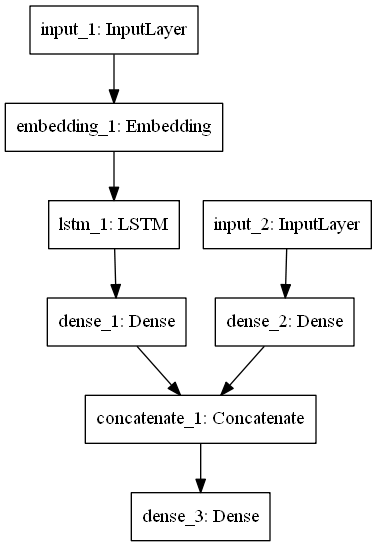

In [9]:
# summarize layers
print(model.summary())
# plot graph
plot_model(model, to_file='shared_feature_extractor.png')

In [10]:
optimzer=Adam(learning_rate=5e-3)
model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy', f1_m, recall_m, precision_m])

In [11]:
train_generator = DataGenerator(train_list, category_labels)
val_generator = DataGenerator(val_list, category_labels, shuffle = False)

save_best = keras.callbacks.ModelCheckpoint('LSTM_GloVe_feature_classification_model.w8', save_weights_only=True,
                                             save_best_only=True, verbose=1)
early_stop = keras.callbacks.EarlyStopping(patience=2)
history = model.fit_generator(generator=train_generator, validation_data=val_generator, verbose = 2, epochs = 5,
                    callbacks=[TQDMNotebookCallback(), save_best, early_stop], workers=1, use_multiprocessing=False) # callbacks=[TQDMNotebookCallback(), save_best, early_stop]
model.load_weights('LSTM_GloVe_feature_classification_model.w8')

Epoch 1/5


 - 7971s - loss: 0.5372 - accuracy: 0.6941 - f1_m: 0.6451 - recall_m: 0.6337 - precision_m: 0.6814 - val_loss: 0.6429 - val_accuracy: 0.6043 - val_f1_m: 0.4655 - val_recall_m: 0.3934 - val_precision_m: 0.6019

Epoch 00001: val_loss improved from inf to 0.64292, saving model to LSTM_GloVe_feature_classification_model.w8
Epoch 2/5


 - 8058s - loss: 0.5291 - accuracy: 0.6957 - f1_m: 0.6482 - recall_m: 0.6366 - precision_m: 0.6816 - val_loss: 0.7541 - val_accuracy: 0.6060 - val_f1_m: 0.4847 - val_recall_m: 0.4226 - val_precision_m: 0.5969

Epoch 00002: val_loss did not improve from 0.64292
Epoch 3/5


 - 8041s - loss: 0.5245 - accuracy: 0.6966 - f1_m: 0.6439 - recall_m: 0.6237 - precision_m: 0.6891 - val_loss: 0.7360 - val_accuracy: 0.6058 - val_f1_m: 0.5052 - val_recall_m: 0.4581 - val_precision_m: 0.5882

Epoch 00003: val_loss did not improve from 0.64292



In [12]:
# -------------------- evaluation on test set -----------------------------

In [13]:
from sklearn.metrics import log_loss, accuracy_score, f1_score, recall_score, precision_score

In [14]:
# get y_true list for all testing samples, order based on test_list
y_true = np.array([category_labels[i] for i in test_list])
n_test = len(test_list)
print(f"there are {n_test} testing examples.")

there are 9236 testing examples.


In [15]:
# let's first take a look at how random guess works
log_loss_guess_min = float('inf')
acc_guess_max = 0
f1_guess_max = 0
recall_guess_max = 0
precision_guess_max = 0
for i in range(100):
    y_guess = np.random.random(n_test)
    log_loss_guess_min = min(log_loss_guess_min, log_loss(y_true, y_guess))
    y_guess = y_guess.round()
    acc_guess_max = max(acc_guess_max, accuracy_score(y_true, y_guess))
    f1_guess_max = max(f1_guess_max, f1_score(y_true, y_guess))
    recall_guess_max = max(recall_guess_max, recall_score(y_true, y_guess))
    precision_guess_max = max(precision_guess_max, precision_score(y_true, y_guess))
print("How random guess works?\n")
print(f"random guess has log_loss around {log_loss_guess_min}.")
print(f"random guess has accuracy around {acc_guess_max}.")
print(f"random guess has f1 score around {f1_guess_max}.")
print(f"random guess has recall around {recall_guess_max}.")
print(f"random guess has precision around {precision_guess_max}.")

How random guess works?

random guess has log_loss around 0.9785186835446419.
random guess has accuracy around 0.5148332611520139.
random guess has f1 score around 0.49372952208789966.
random guess has recall around 0.5182998819362455.
random guess has precision around 0.4733535528596187.


In [38]:
# -- the 1st way to generate predictions for test set --
# access test samples one by one, use model.predict to predict probability for each sample, append it to y_pred_prob_1 list
# y_pred_category_1 gives the category prediction
y_pred_prob_1 = []
for ID in tqdm(test_list):
    X_text = np.load("D:\eluvio\data_\_pad_seq" + str(ID) + ".npy")
    X_feature = np.load("D:\eluvio\data_\_feature" + str(ID) + ".npy")
    y_pred_prob_1.append(model.predict(x = [[X_text], [X_feature]]).flatten()[0])
y_pred_prob_1 = np.array(y_pred_prob_1)
y_pred_category_1 = np.round(K.clip(y_pred_prob_1, 0, 1))

print("In the first way of generating predictions for test set,")
print(f"our model's log_loss is {log_loss(y_true, y_pred_prob_1)}.")
print(f"our model's accuracy is {accuracy_score(y_true, y_pred_category_1)}.")
print(f"our model's f1 score is {f1_score(y_true, y_pred_category_1)}.")
print(f"our model's recall is {recall_score(y_true, y_pred_category_1)}.")
print(f"our model's precision is {precision_score(y_true, y_pred_category_1)}.")
print(f"y_pred_prob head:     {list(np.around(y_pred_prob_1[:20], 2))}")
print(f"y_pred_category head: {list(y_pred_category_1[:20].astype(int))}")
print(f"y_true_category head: {list(y_true[:20])}")

100%|██████████████████████████████████████████████████████████████████████████████| 9236/9236 [03:23<00:00, 44.18it/s]


In the first way of generating predictions for test set,
our model's log_loss is 0.9997163555811566.
our model's accuracy is 0.5991771329579905.
our model's f1 score is 0.47068916213897627.
our model's recall is 0.3886658795749705.
our model's precision is 0.5965929684668358.
y_pred_prob head:     [0.49, 0.0, 0.37, 0.42, 0.0, 0.28, 0.39, 0.0, 0.28, 0.53, 0.27, 0.32, 0.29, 0.48, 0.0, 0.19, 0.45, 0.48, 0.54, 0.44]
y_pred_category head: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
y_true_category head: [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]


In [41]:
# -- the 2nd way generate predictions for test set --
# apply model.predict_generator to test_generator, with shuffle = False
test_generator = DataGenerator(test_list, category_labels, batch_size = n_test, shuffle = False)
y_pred_prob_2 = model.predict_generator(test_generator)
y_pred_prob_2 = y_pred_prob_2.flatten()
y_pred_category_2 = np.round(K.clip(y_pred_prob_2, 0, 1))

print("In the second way of generating predictions for test set,")
print(f"our model's log_loss is {log_loss(y_true, y_pred_prob_2)}.")
print(f"our model's accuracy is {accuracy_score(y_true, y_pred_category_2)}.")
print(f"our model's f1 score is {f1_score(y_true, y_pred_category_2)}.")
print(f"our model's recall is {recall_score(y_true, y_pred_category_2)}.")
print(f"our model's precision is {precision_score(y_true, y_pred_category_2)}.")
print(f"y_pred_prob head:     {list(np.around(y_pred_prob_2[:20], 2))}")
print(f"y_pred_category head: {list(y_pred_category_2[:20].astype(int))}")
print(f"y_true_category head: {list(y_true[:20])}")

In the second way of generating predictions for test set,
our model's log_loss is 0.9997169569300348.
our model's accuracy is 0.5991771329579905.
our model's f1 score is 0.47068916213897627.
our model's recall is 0.3886658795749705.
our model's precision is 0.5965929684668358.
y_pred_prob head:     [0.49, 0.0, 0.37, 0.42, 0.0, 0.28, 0.39, 0.0, 0.28, 0.53, 0.27, 0.32, 0.29, 0.48, 0.0, 0.19, 0.45, 0.48, 0.54, 0.44]
y_pred_category head: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
y_true_category head: [1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1]


In [42]:
# -- the 3rd way to generate predictions for test set --
# apply model.evaluate_generator to test_generator, with shuffle = False
test_generator = DataGenerator(test_list, category_labels, batch_size = n_test, shuffle = False)
logloss, accuracy, f1, recall, precision = model.evaluate_generator(test_generator)
print("In the third way of generating predictions for test set,")
print(f"logloss: {logloss} \naccuracy: {accuracy} \nf1: {f1} \nrecall: {recall} \nprecision: {precision}")

In the third way of generating predictions for test set,
logloss: 0.9997163414955139 
accuracy: 0.5991771221160889 
f1: 0.4706891179084778 
recall: 0.3886658847332001 
precision: 0.5965929627418518


In [24]:
# The prediction and metrics got from all three ways match with each others
(np.round(y_pred_prob_1, 2) == np.round(y_pred_prob_2, 2)).sum() == n_test

True

In [34]:
# get logvotes_labels and compute up_votes = exp(logvotes_labels) - 1
logvotes_labels = np.load("D:\eluvio\data_\logvotes_labels.npy")
test_logvotes = [logvotes_labels[i] for i in test_list]
up_votes = np.round(np.expm1(test_logvotes)).astype(int)

In [37]:
pred_true_df = pd.DataFrame({'pred_prob': y_pred_prob_1, 'pred_category': y_pred_category_1, 'true_category': y_true, 'up_votes': up_votes})
pred_true_df.head(20)

,pred_prob,pred_category,true_category,up_votes
0,0.488183,0.0,1,2098
1,0.001126,0.0,0,4
2,0.371942,0.0,1,7
3,0.418732,0.0,1,27
4,0.001270,0.0,1,34
5,0.278937,0.0,1,31
6,0.389613,0.0,0,3
7,0.001034,0.0,0,1
8,0.279896,0.0,0,0
9,0.528748,1.0,0,4


In [43]:
pred_true_df.to_csv("D:\eluvio\data_\classification_pred.csv")